🎨 Lütfen stil görsellerini yükleyin:


Saving VanGogh.jpg to VanGogh (3).jpg
🖌️ 'VanGogh (3).jpg' için stil ismi giriniz (örn: Van Gogh Yağlı Boya): van gogh

✅ Stil kütüphanesi oluşturuldu. Şimdi içerik görsellerini yükleyip işleyebilirsiniz.
⏹️ Yazmak istediğinizde sadece `bitir` yazın.

Yeni içerik görseli işlemek istiyor musunuz? (evet / bitir): evet

📤 Yeni içerik görseli yükleyin:


Saving cumartesi.JPG to cumartesi (1).JPG

🧠 Kullanılabilir Stil Seçenekleri:
1. van gogh
Uygulanacak stilin numarasını seçin: 1
📊 SSIM (içeriğe göre): 0.7672
🎨 HistSim (stile göre): 0.9831


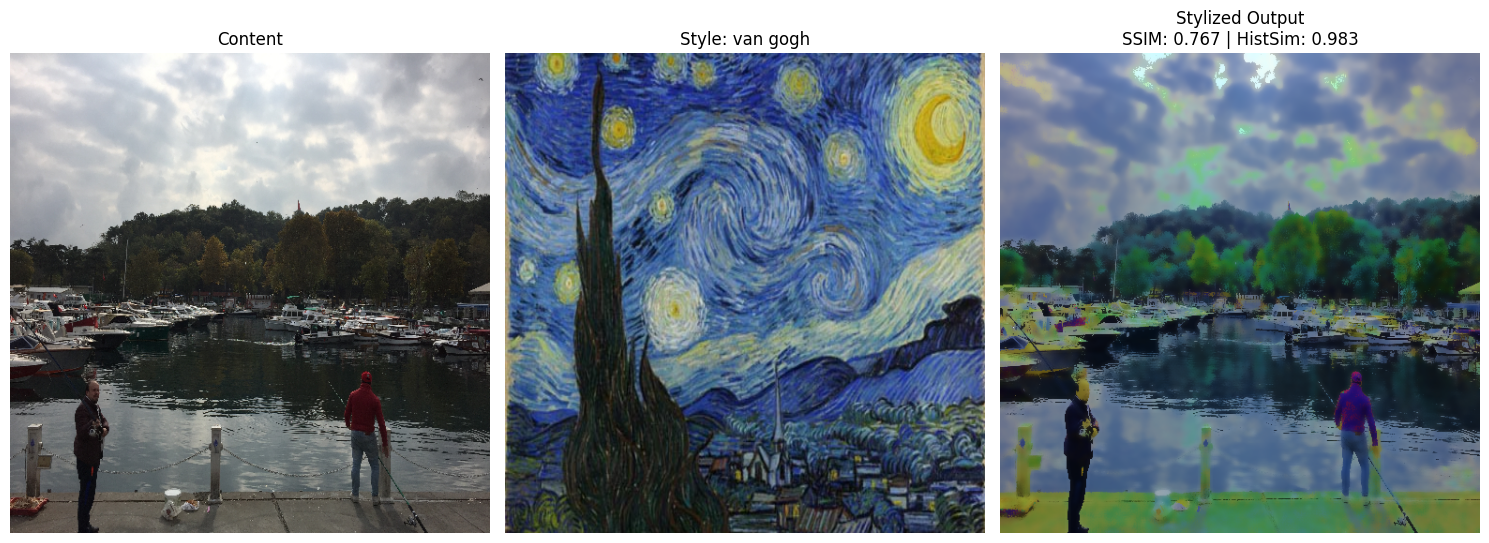

KeyboardInterrupt: Interrupted by user

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io
from skimage.metrics import structural_similarity as ssim

# -------------------- Metrik Fonksiyonları --------------------

def compute_ssim(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    return ssim(gray1, gray2)

def compute_hist_similarity(img1, img2):
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
    sim = 0
    for ch in range(3):
        hist1 = cv2.calcHist([img1_hsv], [ch], None, [256], [0, 256])
        hist2 = cv2.calcHist([img2_hsv], [ch], None, [256], [0, 256])
        hist1 = hist1 / (np.sum(hist1) + 1e-8)
        hist2 = hist2 / (np.sum(hist2) + 1e-8)
        bc = np.sum(np.sqrt(hist1 * hist2))
        sim += bc
    return sim / 3

# -------------------- Görsel İşleme --------------------

def upload_and_name_styles():
    print("🎨 Lütfen stil görsellerini yükleyin:")
    uploaded = files.upload()
    style_dict = {}
    for filename, filedata in uploaded.items():
        img = cv2.imdecode(np.frombuffer(filedata, np.uint8), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (512, 512))
        name = input(f"🖌️ '{filename}' için stil ismi giriniz (örn: Van Gogh Yağlı Boya): ")
        style_dict[name] = img
    return style_dict

def upload_content_image():
    print("\n📤 Yeni içerik görseli yükleyin:")
    uploaded = files.upload()
    filename = next(iter(uploaded))
    img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
    return cv2.resize(img, (512, 512)), filename

def match_histograms_hsv(source, reference):
    source_hsv = cv2.cvtColor(source, cv2.COLOR_BGR2HSV)
    ref_hsv = cv2.cvtColor(reference, cv2.COLOR_BGR2HSV)
    matched = np.zeros_like(source_hsv)
    for i in range(3):
        src_hist, _ = np.histogram(source_hsv[..., i].flatten(), 256, [0, 256])
        ref_hist, _ = np.histogram(ref_hsv[..., i].flatten(), 256, [0, 256])
        src_cdf = np.cumsum(src_hist).astype(np.float32) / src_hist.sum()
        ref_cdf = np.cumsum(ref_hist).astype(np.float32) / ref_hist.sum()
        mapping = np.interp(src_cdf, ref_cdf, np.arange(256))
        matched[..., i] = cv2.LUT(source_hsv[..., i], mapping.astype(np.uint8))
    return cv2.cvtColor(matched, cv2.COLOR_HSV2BGR)

def extract_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    blurred = cv2.GaussianBlur(edges, (7, 7), sigmaX=3)
    return cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)

def overlay_edges(img, edge_map, alpha=0.1):
    return cv2.addWeighted(img, 1.0, edge_map, alpha, 0)

def stylize(content_img, style_img):
    hist_matched = match_histograms_hsv(content_img, style_img)
    stylized = cv2.bilateralFilter(hist_matched, d=9, sigmaColor=75, sigmaSpace=75)
    edge_map = extract_edges(content_img)
    return overlay_edges(stylized, edge_map, alpha=0.1)

# -------------------- Ana Akış --------------------

style_dict = upload_and_name_styles()

print("\n✅ Stil kütüphanesi oluşturuldu. Şimdi içerik görsellerini yükleyip işleyebilirsiniz.")
print("⏹️ Yazmak istediğinizde sadece `bitir` yazın.")

while True:
    user_input = input("\nYeni içerik görseli işlemek istiyor musunuz? (evet / bitir): ").strip().lower()
    if user_input == "bitir":
        print("✅ İşlem tamamlandı. Kod sonlandırıldı.")
        break
    elif user_input != "evet":
        print("⚠️ Lütfen sadece 'evet' ya da 'bitir' yazınız.")
        continue

    content_img, content_filename = upload_content_image()

    print("\n🧠 Kullanılabilir Stil Seçenekleri:")
    for idx, name in enumerate(style_dict.keys()):
        print(f"{idx + 1}. {name}")

    try:
        choice = int(input("Uygulanacak stilin numarasını seçin: ")) - 1
        style_name = list(style_dict.keys())[choice]
    except:
        print("⚠️ Geçersiz seçim. Stil uygulanamadı.")
        continue

    style_img = style_dict[style_name]
    result_img = stylize(content_img, style_img)

    # Metrik Hesapla
    ssim_score = compute_ssim(content_img, result_img)
    hist_score = compute_hist_similarity(style_img, result_img)
    print(f"📊 SSIM (içeriğe göre): {ssim_score:.4f}")
    print(f"🎨 HistSim (stile göre): {hist_score:.4f}")

    # Görsel Göster
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)); ax[0].set_title("Content"); ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)); ax[1].set_title(f"Style: {style_name}"); ax[1].axis("off")
    ax[2].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title(f"Stylized Output\nSSIM: {ssim_score:.3f} | HistSim: {hist_score:.3f}")
    ax[2].axis("off")
    plt.tight_layout()
    plt.show()


📤 🎨 Stil görselini yükleyin


Saving VanGogh.jpg to VanGogh (4).jpg

📤 🖼️ İçerik görselini yükleyin


Saving cumartesi.JPG to cumartesi (2).JPG


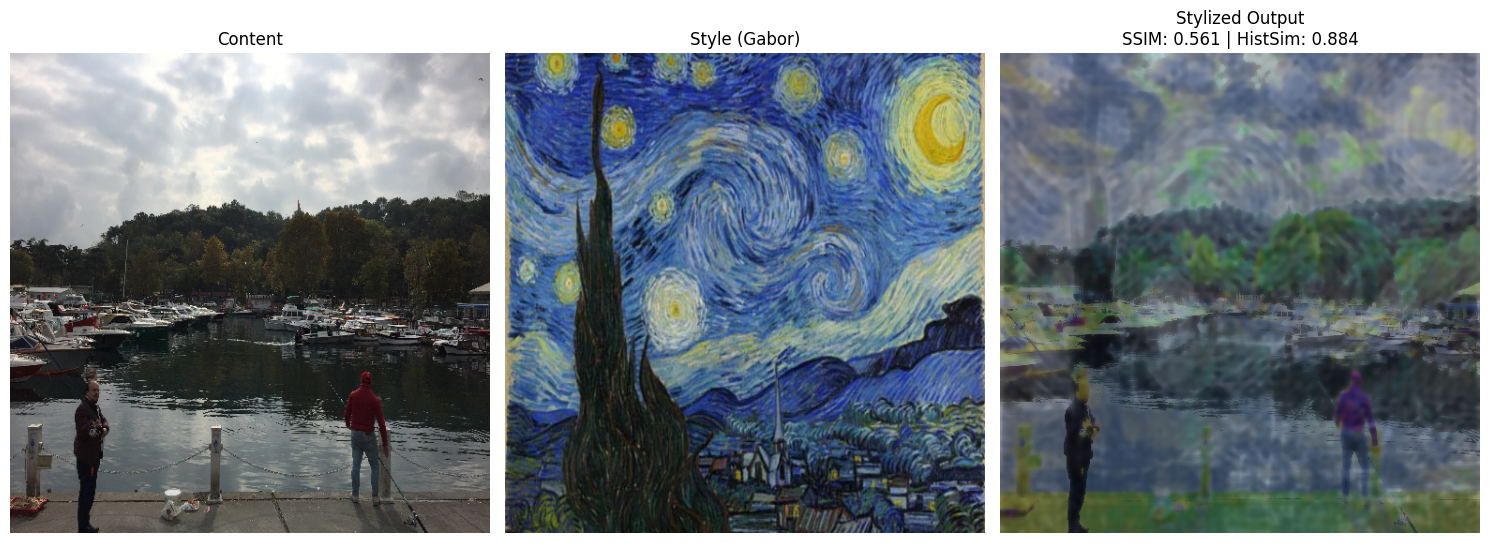

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import structural_similarity as ssim

# Gabor filtrelerini uygula (stil görseli üzerinden)
def extract_gabor_texture(image, ksize=31):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    accum = np.zeros_like(gray, dtype=np.float32)
    for theta in np.arange(0, np.pi, np.pi / 4):
        kernel = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        fimg = cv2.filter2D(gray, cv2.CV_32F, kernel)
        accum += np.abs(fimg)
    accum = cv2.normalize(accum, None, 0, 255, cv2.NORM_MINMAX)
    texture = cv2.cvtColor(accum.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    return texture

# Histogram eşleştirme (HSV)
def match_histograms_hsv(source, reference):
    source_hsv = cv2.cvtColor(source, cv2.COLOR_BGR2HSV)
    ref_hsv = cv2.cvtColor(reference, cv2.COLOR_BGR2HSV)
    matched = np.zeros_like(source_hsv)
    for i in range(3):
        src_hist, _ = np.histogram(source_hsv[..., i].flatten(), 256, [0, 256])
        ref_hist, _ = np.histogram(ref_hsv[..., i].flatten(), 256, [0, 256])
        src_cdf = np.cumsum(src_hist).astype(np.float32) / src_hist.sum()
        ref_cdf = np.cumsum(ref_hist).astype(np.float32) / ref_hist.sum()
        mapping = np.interp(src_cdf, ref_cdf, np.arange(256))
        matched[..., i] = cv2.LUT(source_hsv[..., i], mapping.astype(np.uint8))
    return cv2.cvtColor(matched, cv2.COLOR_HSV2BGR)

# Kenar çıkarımı ve bindirme
def extract_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    blurred = cv2.GaussianBlur(edges, (7, 7), sigmaX=3)
    return cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)

def overlay_edges(img, edge_map, alpha=0.15):
    return cv2.addWeighted(img, 1.0, edge_map, alpha, 0)

# Stil aktarımı (Gabor + HSV + Edge Fusion)
def stylize_with_gabor(content_img, style_img):
    hist_matched = match_histograms_hsv(content_img, style_img)
    gabor_texture = extract_gabor_texture(style_img)
    combined = cv2.addWeighted(hist_matched, 0.6, gabor_texture, 0.4, 0)
    smoothed = cv2.bilateralFilter(combined, d=9, sigmaColor=75, sigmaSpace=75)
    edge_map = extract_edges(content_img)
    final = overlay_edges(smoothed, edge_map, alpha=0.15)
    return final

# --- Metrik Fonksiyonları ---

def compute_ssim(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    return ssim(gray1, gray2)

def compute_hist_similarity(img1, img2):
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
    sim = 0
    for ch in range(3):
        hist1 = cv2.calcHist([img1_hsv], [ch], None, [256], [0, 256])
        hist2 = cv2.calcHist([img2_hsv], [ch], None, [256], [0, 256])

        # Doğru normalize et (L1 normu: toplam = 1)
        hist1 = hist1 / (np.sum(hist1) + 1e-8)
        hist2 = hist2 / (np.sum(hist2) + 1e-8)

        bc = np.sum(np.sqrt(hist1 * hist2))  # Bhattacharyya coefficient ∈ [0,1]
        sim += bc
    return sim / 3  # Ortalama 3 kanal benzerliği



# Stil ve içerik yükle
def load_image(title="Görsel seçin"):
    print(f"\n📤 {title}")
    uploaded = files.upload()
    fname = next(iter(uploaded))
    img = cv2.imdecode(np.frombuffer(uploaded[fname], np.uint8), cv2.IMREAD_COLOR)
    return cv2.resize(img, (512, 512)), fname

# Ana akış
style_img, _ = load_image("🎨 Stil görselini yükleyin")
content_img, _ = load_image("🖼️ İçerik görselini yükleyin")

result = stylize_with_gabor(content_img, style_img)

# Metrikleri hesapla
ssim_score = compute_ssim(content_img, result)
hist_sim = compute_hist_similarity(style_img, result)

# Sonuçları göster
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)); ax[0].set_title("Content"); ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)); ax[1].set_title("Style (Gabor)"); ax[1].axis("off")
ax[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)); ax[2].set_title(f"Stylized Output\nSSIM: {ssim_score:.3f} | HistSim: {hist_sim:.3f}"); ax[2].axis("off")
plt.tight_layout()
plt.show()


📤 🎨 Stil görselini yükleyin


Saving VanGogh.jpg to VanGogh (1).jpg

📤 🖼️ İçerik görselini yükleyin


Saving park.png to park (1).png
📊 SSIM (içeriğe göre): 0.0495
🎨 HistSim (stile göre): 0.3272


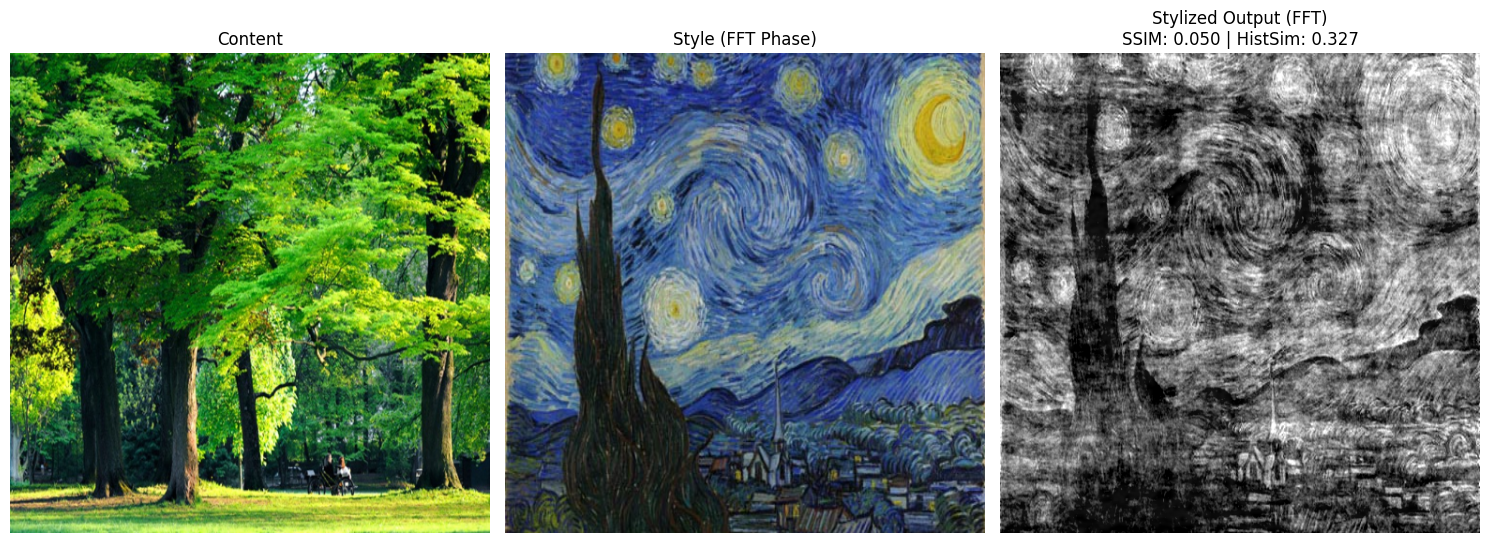

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import structural_similarity as ssim

# -------------------- Metrik Fonksiyonları --------------------

def compute_ssim(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    return ssim(gray1, gray2)

def compute_hist_similarity(img1, img2):
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
    sim = 0
    for ch in range(3):
        hist1 = cv2.calcHist([img1_hsv], [ch], None, [256], [0, 256])
        hist2 = cv2.calcHist([img2_hsv], [ch], None, [256], [0, 256])
        hist1 = hist1 / (np.sum(hist1) + 1e-8)
        hist2 = hist2 / (np.sum(hist2) + 1e-8)
        bc = np.sum(np.sqrt(hist1 * hist2))
        sim += bc
    return sim / 3

# -------------------- FFT Tabanlı Stil Aktarımı --------------------

def fft_style_transfer(content_img, style_img):
    content_gray = cv2.cvtColor(content_img, cv2.COLOR_BGR2GRAY)
    style_gray = cv2.cvtColor(style_img, cv2.COLOR_BGR2GRAY)
    f_content = np.fft.fft2(content_gray)
    f_style = np.fft.fft2(style_gray)
    mag_content = np.abs(f_content)
    phase_style = np.angle(f_style)
    combined = mag_content * np.exp(1j * phase_style)
    stylized_gray = np.fft.ifft2(combined).real
    stylized_gray = np.clip(stylized_gray, 0, 255).astype(np.uint8)
    stylized = cv2.cvtColor(stylized_gray, cv2.COLOR_GRAY2BGR)
    return stylized

def extract_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    blurred = cv2.GaussianBlur(edges, (7, 7), sigmaX=2)
    return cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)

def overlay_edges(img, edge_map, alpha=0.15):
    return cv2.addWeighted(img, 1.0, edge_map, alpha, 0)

def stylize_with_fft(content_img, style_img):
    base = fft_style_transfer(content_img, style_img)
    edge_map = extract_edges(content_img)
    result = overlay_edges(base, edge_map, alpha=0.15)
    return result

def load_image(title="Görsel seçin"):
    print(f"\n📤 {title}")
    uploaded = files.upload()
    fname = next(iter(uploaded))
    img = cv2.imdecode(np.frombuffer(uploaded[fname], np.uint8), cv2.IMREAD_COLOR)
    return cv2.resize(img, (512, 512)), fname

# -------------------- Ana Akış --------------------

style_img, _ = load_image("🎨 Stil görselini yükleyin")
content_img, _ = load_image("🖼️ İçerik görselini yükleyin")

result = stylize_with_fft(content_img, style_img)

# Metrik Hesapla
ssim_score = compute_ssim(content_img, result)
hist_score = compute_hist_similarity(style_img, result)
print(f"📊 SSIM (içeriğe göre): {ssim_score:.4f}")
print(f"🎨 HistSim (stile göre): {hist_score:.4f}")

# Sonuçları göster
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)); ax[0].set_title("Content"); ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)); ax[1].set_title("Style (FFT Phase)"); ax[1].axis("off")
ax[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax[2].set_title(f"Stylized Output (FFT)\nSSIM: {ssim_score:.3f} | HistSim: {hist_score:.3f}")
ax[2].axis("off")
plt.tight_layout()
plt.show()


📤 🎨 Stil görselini yükleyin


Saving andywarhol.jpg to andywarhol (1).jpg

📤 🖼️ İçerik görselini yükleyin


Saving cumartesi.JPG to cumartesi (3).JPG
🔎 CANNY → SSIM: 0.5071, HistSim: 0.9062
🔎 SOBEL → SSIM: 0.5017, HistSim: 0.9138
🔎 LAPLACIAN → SSIM: 0.5108, HistSim: 0.9090


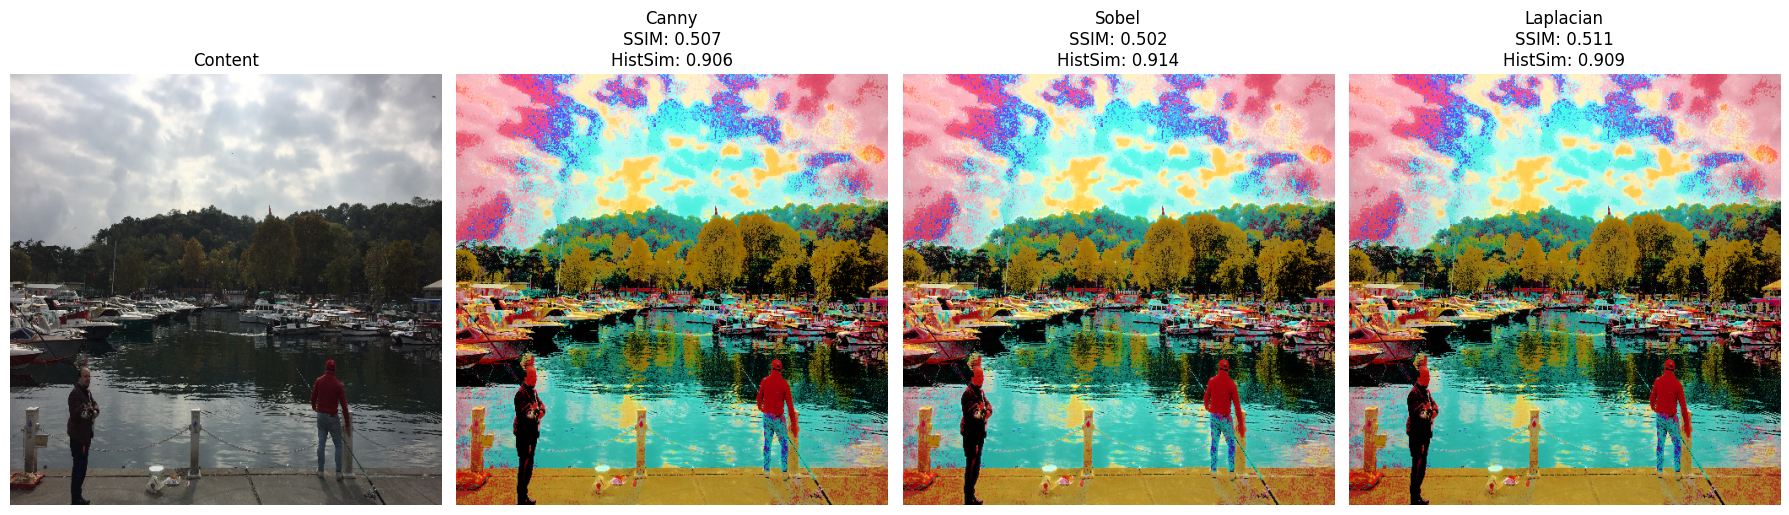

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import structural_similarity as ssim

# -------------------- Metrik Fonksiyonları --------------------

def compute_ssim(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    return ssim(gray1, gray2)

def compute_hist_similarity(img1, img2):
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
    sim = 0
    for ch in range(3):
        hist1 = cv2.calcHist([img1_hsv], [ch], None, [256], [0, 256])
        hist2 = cv2.calcHist([img2_hsv], [ch], None, [256], [0, 256])
        hist1 = hist1 / (np.sum(hist1) + 1e-8)
        hist2 = hist2 / (np.sum(hist2) + 1e-8)
        bc = np.sum(np.sqrt(hist1 * hist2))
        sim += bc
    return sim / 3

# -------------------- Stil Aktarım Fonksiyonları --------------------

def extract_edge_map(img, method="canny"):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if method == "canny":
        edge = cv2.Canny(gray, 100, 200)
    elif method == "sobel":
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edge = cv2.convertScaleAbs(np.sqrt(grad_x**2 + grad_y**2))
    elif method == "laplacian":
        edge = cv2.Laplacian(gray, cv2.CV_64F)
        edge = cv2.convertScaleAbs(edge)
    else:
        raise ValueError("Geçersiz kenar yöntemi")
    blurred = cv2.GaussianBlur(edge, (5, 5), sigmaX=2)
    return cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR)

def match_histograms_hsv(source, reference):
    source_hsv = cv2.cvtColor(source, cv2.COLOR_BGR2HSV)
    ref_hsv = cv2.cvtColor(reference, cv2.COLOR_BGR2HSV)
    matched = np.zeros_like(source_hsv)
    for i in range(3):
        src_hist, _ = np.histogram(source_hsv[..., i].flatten(), 256, [0, 256])
        ref_hist, _ = np.histogram(ref_hsv[..., i].flatten(), 256, [0, 256])
        src_cdf = np.cumsum(src_hist).astype(np.float32) / src_hist.sum()
        ref_cdf = np.cumsum(ref_hist).astype(np.float32) / ref_hist.sum()
        mapping = np.interp(src_cdf, ref_cdf, np.arange(256))
        matched[..., i] = cv2.LUT(source_hsv[..., i], mapping.astype(np.uint8))
    return cv2.cvtColor(matched, cv2.COLOR_HSV2BGR)

def overlay_edges(img, edge_map, alpha=0.1):
    return cv2.addWeighted(img, 1.0, edge_map, alpha, 0)

def stylize_with_edge_variant(content_img, style_img, edge_method):
    hist_matched = match_histograms_hsv(content_img, style_img)
    edge_map = extract_edge_map(content_img, method=edge_method)
    stylized = overlay_edges(hist_matched, edge_map, alpha=0.12)
    return stylized

# -------------------- Görsel Yükleme --------------------

def load_image(title="Görsel seçin"):
    print(f"\n📤 {title}")
    uploaded = files.upload()
    fname = next(iter(uploaded))
    img = cv2.imdecode(np.frombuffer(uploaded[fname], np.uint8), cv2.IMREAD_COLOR)
    return cv2.resize(img, (512, 512)), fname

# -------------------- Ana Akış --------------------

style_img, _ = load_image("🎨 Stil görselini yükleyin")
content_img, _ = load_image("🖼️ İçerik görselini yükleyin")

methods = ["canny", "sobel", "laplacian"]
results = {}
metrics = {}

for method in methods:
    result = stylize_with_edge_variant(content_img, style_img, method)
    results[method] = result
    ssim_val = compute_ssim(content_img, result)
    hist_val = compute_hist_similarity(style_img, result)
    metrics[method] = (ssim_val, hist_val)
    print(f"🔎 {method.upper()} → SSIM: {ssim_val:.4f}, HistSim: {hist_val:.4f}")

# -------------------- Görsel Karşılaştırması --------------------

fig, ax = plt.subplots(1, 4, figsize=(18, 6))
ax[0].imshow(cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)); ax[0].set_title("Content"); ax[0].axis("off")

for i, method in enumerate(methods):
    result_img = results[method]
    ssim_val, hist_val = metrics[method]
    ax[i + 1].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    ax[i + 1].set_title(f"{method.capitalize()}\nSSIM: {ssim_val:.3f}\nHistSim: {hist_val:.3f}")
    ax[i + 1].axis("off")

plt.tight_layout()
plt.show()